# SciKit-learn classifier testing results

## Notebook set-up

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Data loading

In [2]:
data_file='../data/processed/02.1-no-multicollinearity_one_hot_ordinal_nan_imputed_data_df.pkl'

with open(data_file, 'rb') as input_file:
    data_dict=pickle.load(input_file)

data_file='../data/results/data/sklearn_classifier_test.pkl'

with open(data_file, 'rb') as input_file:
    results=pickle.load(input_file)

print(f'Models: {list(results.keys())}')

Models: ['Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Polynomial SVM', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'Neural Net', 'AdaBoost', 'Naive Bayes', 'QDA', 'XGBoost']


## 2. Baseline performance

In [3]:
dumb_guess=sum(data_dict['Testing labels']['efs'])/len(data_dict['Testing labels']['efs'])*100
print(f'Baseline model performance: {dumb_guess:.1f}%')

Baseline model performance: 54.0%


## 3. Cross-validation performance

In [4]:
results_dfs=[]

for model, data in results.items():
    print(model)

    results_dfs.append(pd.DataFrame.from_dict({'Model': [model]*len(data['Cross validation scores']), 'Cross-validation scores': data['Cross validation scores']}))

results_df=pd.concat(results_dfs, axis=0)
results_df.head()

Nearest Neighbors
Linear SVM
RBF SVM
Polynomial SVM
Gaussian Process
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
XGBoost


,Model,Cross-validation scores
0,Nearest Neighbors,0.615575
1,Nearest Neighbors,0.616237
2,Nearest Neighbors,0.615079
3,Nearest Neighbors,0.621032
4,Nearest Neighbors,0.606978


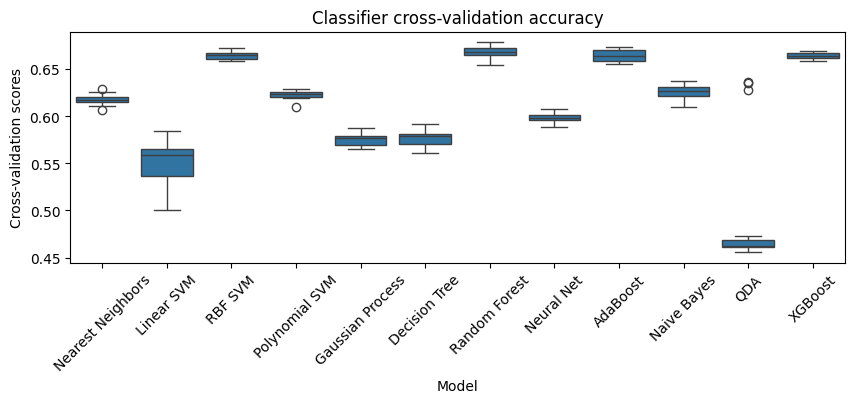

In [5]:
fig, ax=plt.subplots(1,1, figsize=(10,3))

ax.set_title('Classifier cross-validation accuracy')
sns.boxplot(results_df, x='Model', y='Cross-validation scores', ax=ax)
ax.tick_params(axis='x', labelrotation=45)
fig.show()

## 4. Test set performance

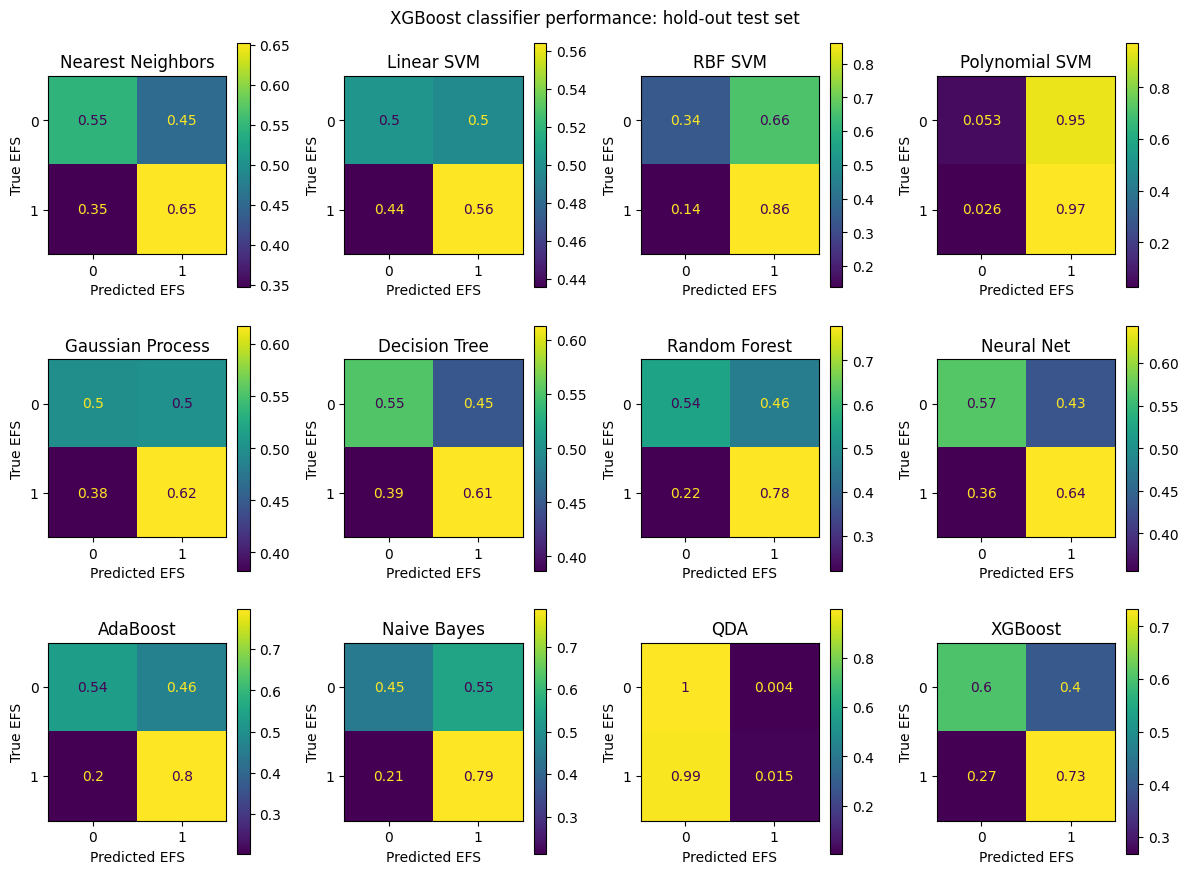

In [6]:
rows=len(results.keys()) // 4

fig, axs=plt.subplots(rows,4, figsize=(12,3*rows))
axs=axs.flatten()

fig.suptitle('XGBoost classifier performance: hold-out test set')

for i, (model, data) in enumerate(results.items()):

    # Plot the confusion matrix
    cm=confusion_matrix(data_dict['Testing labels']['efs'], data['Testing predictions'], normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(model)
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.show()